## Проект: вариант 1
Я выбрал данный вариант финального проекта, потому что мне близка тема игр, и я бы хотел посмотреть на нее не со стороны пользователя, а со стороны аналитика игр.

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import norm
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:\
shared/problem1-reg_data.csv – данные о времени регистрации\
shared/problem1-auth_data.csv – данные о времени захода пользователей в игру\
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

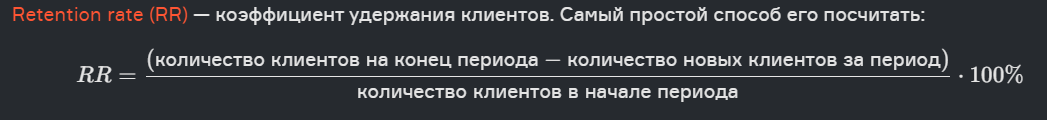

Будем использовать "Retention n-ого дня", так как он лучше подходит для приложений в которые люди должны возвращаться постоянно в отличии от "Rolling Retention", который подразумевает редкое возвращение юзеров в приложение

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [3]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [4]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [5]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [6]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [7]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [9]:
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [10]:
# изменяем типы данных
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s')
reg_data['reg_ts'] = reg_data.reg_ts.dt.date
auth_data['auth_ts'] = auth_data.auth_ts.dt.date

In [17]:
# функиця "Retention" принимает день, с которого начинаем сичтать метрику и количество дней которое ее считаем.
# возвращает датафрейм с выбранными днями, количество вернувшихся пользователей в этот день,
# которые зарегестрировались в указанный день
# и столбец retention это наша метрика
def Retention(first_day, days):
    
    # присваиваем первый и последний день
    first_day = pd.to_datetime(first_day)
    last_day = first_day + timedelta(days=days)
    
    # объединяем таблицы
    data = reg_data.merge(auth_data, on='uid').query('reg_ts >= @first_day & auth_ts < @last_day') # last_day используется
    
    # cоздаем массив с уникальными пользователями в первый день
    df = data.query('reg_ts == @first_day')
    unique_users = df['uid'].tolist()
    unique_users = list(dict.fromkeys(unique_users))
    
    # создаем итоговый массив для подсчета retention 
    data = data.query('uid in @unique_users') \
                .groupby('auth_ts', as_index=False) \
                .agg({'uid':'nunique'}) \
                .rename(columns={'uid': 'users' , 'auth_ts': 'day'})
    
    # создаем столбец retention
    data['retention'] = (data['users']) / len(unique_users) * 100
    
    # график
    plt.figure(figsize=(15, 10))
    plt.title('Retention', fontsize = 17)
    sns.lineplot(x=data.day[1:days], y=data.retention)

    return data

,day,users,retention
0,2020-05-23,1343,100.000000
1,2020-05-24,27,2.010424
2,2020-05-25,53,3.946389
3,2020-05-26,56,4.169769
4,2020-05-27,64,4.765450
...,...,...,...
115,2020-09-15,21,1.563663
116,2020-09-16,16,1.191363
117,2020-09-17,16,1.191363
118,2020-09-18,23,1.712584


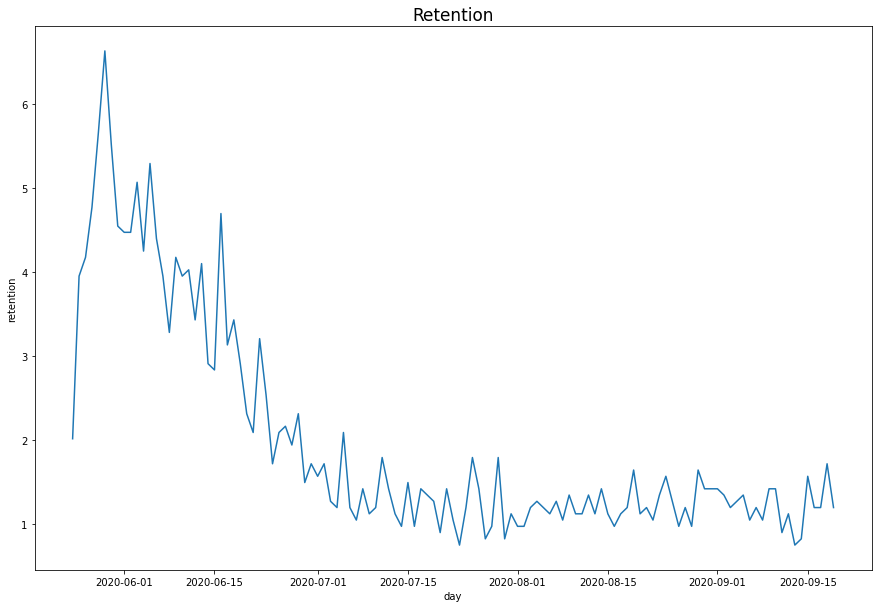

In [18]:
# пример работы функции
Retention("2020-05-23", 120)

,day,users,retention
0,2020-01-01,1061,100.000000
1,2020-01-02,28,2.639020
2,2020-01-03,48,4.524034
3,2020-01-04,36,3.393025
4,2020-01-05,60,5.655042
5,2020-01-06,62,5.843544
6,2020-01-07,80,7.540057


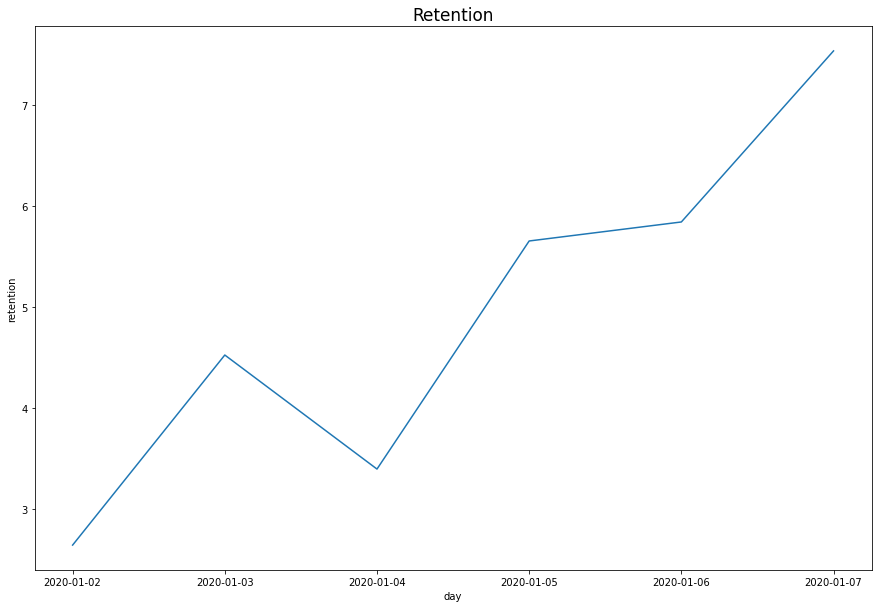

In [19]:
Retention("2020-01-01", 7)

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
df = pd.read_csv('~/Проект_1_Задание_2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [3]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [4]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [5]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

построим графики распределения показателя revenue в зависимости от группы в testgroup

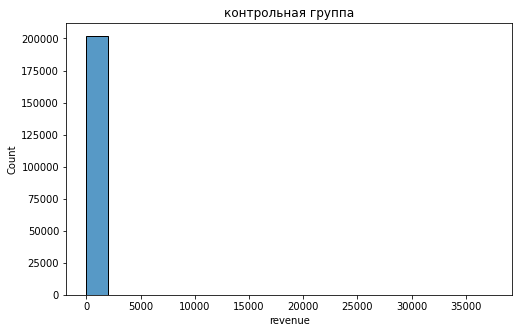

In [7]:
plt.figure(figsize=(8, 5))
a_hist = sns.histplot(data=df.query('testgroup == "a"'), x='revenue')
a_hist.set(title='контрольная группа')
plt.show()

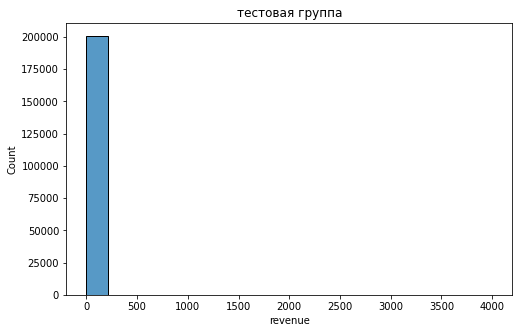

In [8]:
plt.figure(figsize=(8, 5))
b_hist = sns.histplot(data=df.query('testgroup == "b"'), x='revenue')
b_hist.set(title='тестовая группа')
plt.show()

много нулей, посмотри на распределение без них

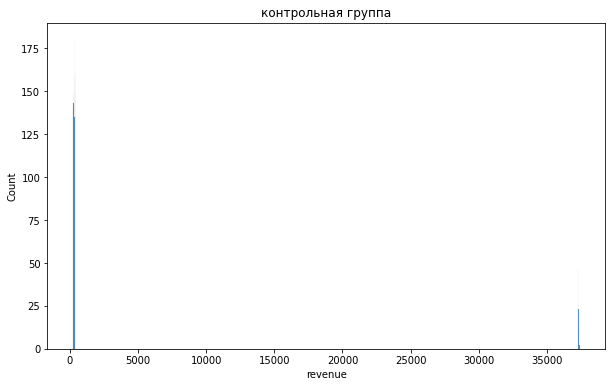

In [9]:
plt.figure(figsize=(10, 6))
a_hist = sns.histplot(data=df.query('testgroup == "a" & revenue > 0'), x='revenue')
a_hist.set(title='контрольная группа')
plt.show()

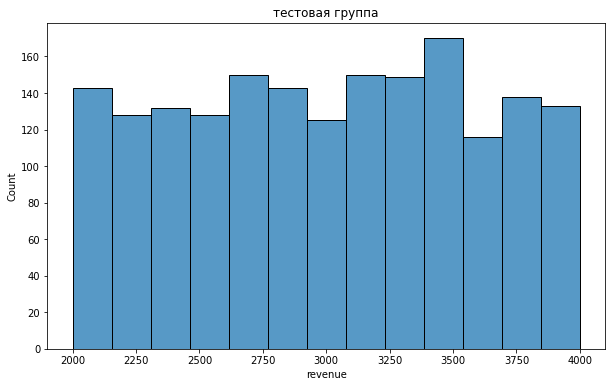

In [10]:
plt.figure(figsize=(10, 6))
b_hist = sns.histplot(data=df.query('testgroup == "b" & revenue > 0'), x='revenue')
b_hist.set(title='тестовая группа')
plt.show()

как можно заметить в контрольной группе наблюдения поделены на две части: около нуля, и которые больше 35000\
посмотрим на них ближе

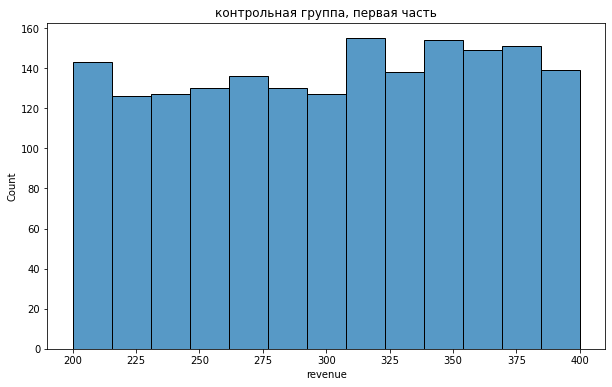

In [11]:
plt.figure(figsize=(10, 6))
a_hist = sns.histplot(data=df.query('testgroup == "a" & revenue > 0 & revenue < 20000'), x='revenue')
a_hist.set(title='контрольная группа, первая часть')
plt.show()

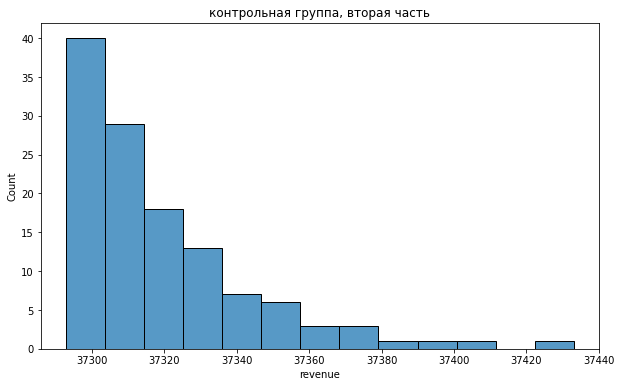

In [12]:
plt.figure(figsize=(10, 6))
a_hist = sns.histplot(data=df.query('testgroup == "a" & revenue > 20000'), x='revenue')
a_hist.set(title='контрольная группа, вторая часть')
plt.show()

### подведем итог исследования: все наши наблдюдения делятся на 4 типа:
### 1) revenue равно 0 и в контрольной и в тестой группе (данный тип нас не интересует)
### 2) revenue больше 200, но меньше 400. Принадлежит только контрольной группе
### 3) revenue больше 37300, но меньше 37440. Принадлежит только контрольной группе
### 4) revenue больше 2000, но меньше 4000. Принадлежит только тестовой группе

посчитаем доходности групп и типов

In [13]:
df.head(2)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a


In [14]:
df.query('testgroup == "a"').revenue.sum()
# сумма дохода в контрольной группе

5136189

In [15]:
df.query('testgroup == "b"').revenue.sum()
# сумма дохода в тестовой группе

5421603

In [16]:
df.query('testgroup == "a" & revenue > 0').user_id.count()
# количество покупателей в контрольной группе

1928

In [17]:
df.query('testgroup == "b" & revenue > 0').user_id.count()
# количество покупателей в тестовой группе

1805

In [18]:
df.query('testgroup == "a" & revenue > 0 & revenue < 20000').user_id.count()
# количество покупателей в контрольной группе во втором типе

1805

In [19]:
df.query('testgroup == "a" & revenue > 20000').user_id.count()
# количество покупателей в контрольной группе в третьем типе

123

как мы можем заметить количество платящих пользователей в контрольной и в тестовой группе разное.\
При чем стоит отметить, что есть группа платящих пользователей в контрольной группе (3 тип), которых 123 плата которых сильно отличается от всех остальных (намного больше) и самих пользователей мало. Назвать это выбросом нельзя так как их 123 что составляет чуть больше 6 процентов от кол-ва платящих пользователей в контрольной группе. \
И можно подметить, что без этой группы (3 тип), количество в контрольной и в тестовой группе уравняется и будет равно 1805.

In [20]:
df.query('testgroup == "a" & revenue > 0 & revenue < 20000').revenue.sum()
# сумма дохода в контрольной группе во втором типе

545937

In [21]:
df.query('testgroup == "a" & revenue > 20000').revenue.sum()
# сумма дохода в контрольной группе в третьем типе

4590252

дохожы также сильно разные и по сути без этих 123 людей в контрольной группе, суммарный доход в тестовой группе в 9.93 раза больше чем в контрольной

In [22]:
5421603 / 545937

9.930821688216772

In [23]:
df.query('testgroup == "a"& revenue > 0').revenue.mean()
# ARPU в контрольной группе

2663.9984439834025

In [24]:
df.query('testgroup == "b"& revenue > 0').revenue.mean()
# ARPU в тестовой группе

3003.6581717451522

In [25]:
df.query('testgroup == "a" & revenue > 0 & revenue < 20000').revenue.mean()
# ARPU в контрольной группе во втором типе

302.45817174515236

In [26]:
df.query('testgroup == "a" & revenue > 20000').revenue.mean()
# ARPU в контрольной группе в третьем типе

37319.12195121951

Соответсвенно и метрика ARPU также абсолютно разная

### подкрепим наши выводы, проведя бустстрап тестирование
(воспользуемся функцией из лекции)

In [27]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

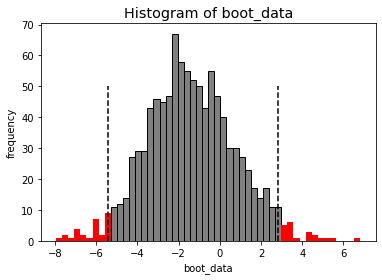

In [28]:
ARPU_booted_data = get_bootstrap(
                    df.query('testgroup == "a"').revenue,
                    df.query('testgroup == "b"').revenue)

In [29]:
ARPU_booted_data["p_value"]

0.5125159192114619

In [30]:
ARPU_booted_data['quants']

,0
0.025,-5.406912
0.975,2.839756


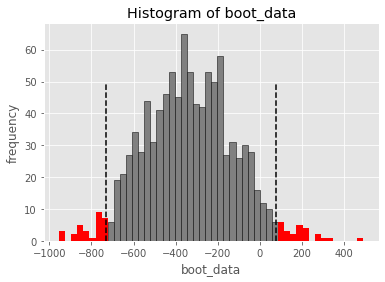

In [31]:
ARPPU_booted_data = get_bootstrap(
                    df.query('testgroup == "a" & revenue > 0').revenue,
                    df.query('testgroup == "b" & revenue > 0').revenue)

In [32]:
ARPPU_booted_data["p_value"]

0.11519358712273485

In [33]:
ARPPU_booted_data['quants']

,0
0.025,-731.530031
0.975,75.923574


### посмотрим конверсию в покупку в двух группах

In [34]:
# контрольная группа
1928 / 202103 * 100

0.9539690157988748

In [35]:
# контрольная группа
1805 / 202667 * 100

0.8906235351586593

### конверсия в контрольной группе выше, чем в тестовой

In [44]:
import scipy.stats as stats

In [53]:
df['paid'] = df.revenue > 0

In [59]:
conv = pd.crosstab(df['testgroup'], df['paid'])
conv

paid,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [65]:
result = chi2_contingency(conv)

In [66]:
# p-value
result[1]

0.03647561892312613

In [68]:
# хи-квадрат статистика
result[0]

4.374729521260405

### Проверили с помощью тест хи-квадрат и получили p-value < 0.05. 
### Это значит, что различия между конверсия в двух группах стат значимы

## 1) Какой набор предложений можно считать лучшим?
### С помощью bootstrap мы проверили что разница в 5% является статистически незначимой так как p-value > 0.05, то есть значимых различий в ARPU и ARPPU между двумя выборками нет. Однако мы также посмотрели на конверсию в двух группах. При том, что конверсия в контрольной группе вышем, чем в тестовой, ARPU в тестовой группе выше на 5%, чем в контрольной. А это значит, что в тестовой группе при меньшем количестве платящих пользователей доход выше. Поэтому стоит выбрать именно тестовую группу.
## 2) Какие метрики стоит проанализировать для принятия правильного решения и как?
### Мы проанализировали две метрики: ARPU и ARPPU и как выяснилось они точно не могут дать ответ на то, какая группа лучше. Но CR метрика смогла помочь в принятии решений.
### 3) Я считаю, что нужно заново пересобрать группы, так как из графиков и подсчетов видно, что пользователи в группах разные.

# Задание 3


В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### С помощью каких метрик можно оценить результаты последнего прошедшего события?
Чтобы оценить количество уникальных пользователей, которые зашли в приложение во время ивента, можно использовать метрики: Дневная аудитория (DAU), Средняя дневная аудитория, Месячная аудитория (MAU), Доля новых пользователей.\
Можно сравнить количество пользователей в последнем ивенте с предыдущими и посмотреть динамику.\
Также можно посмотреть конверсию пользователей, которые проходят уровни.\
Если в ивенте есть платный контент, то нужно сравнить показатели доходов ARPU и ARPPU.

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?
При усложнении механики, вышеперечисленные метрики остаются актуальными, однако можно добавить другие метрики.\
Для начала нужно посмотреть какие уровни являются сложными, с каких уровней больше всего люди откатываются назад.\
Можно посмотреть на каком уровне люди чаще всего застревают и покидают ивент.\
Посмотреть есть ли люди, которые прошли ивент полностью и сколько им потребовалось попыток на это.\
Также стоит сравнить два этих подхода и посмотреть, при каком из подходов пользователи более лояльны к игре.